### Prepare the bike trips data and weather data we combined for regression training. Our goal is to predict the number of bike trips based on the features space. we will aggregate the data by  "num_week" , "weekday" and "hour" to get the number of bike trips for each time slot.

#### Step:1- Prepare the data

In [1]:
import pandas as pd

def prepareData(df):

    # Convert to datetime
    df['start_date'] = pd.to_datetime(df['start_date'])

    df['weekday'] = df['start_date'].dt.dayofweek
    df['hour'] = df['start_date'].dt.hour
    df['num_week'] = df['start_date'].dt.isocalendar().week

    df = df.drop(['start_date','start_station_code', 'end_date', 'end_station_code', 'duration_sec', 'is_member', 'Temperature_C'], axis=1)

    # Group by hour
    df_agrupado = df.groupby(['num_week','weekday', 'hour']).agg('first')

    columna = df.groupby(['num_week','weekday', 'hour']).count()['Description']
    df_agrupado['count'] = columna

    # To convert these indices (num_week, weekday, hour) back into columns, use the reset_index method:
    df_agrupado=df_agrupado.reset_index(level=[0,1,2])

    return df_agrupado
    

In [2]:

OD_2014_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather.csv')
OD_2014_weather_agg = prepareData(OD_2014_weather_agg)

OD_2015_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather.csv')
OD_2015_weather_agg = prepareData(OD_2015_weather_agg)

OD_2016_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather.csv')
OD_2016_weather_agg = prepareData(OD_2016_weather_agg)

OD_2017_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather.csv')
OD_2017_weather_agg = prepareData(OD_2017_weather_agg)

OD_2014_weather_agg.head()

,num_week,weekday,hour,Description,Temperature,Pressure,Wind_speed,count
0,16,1,3,light rain,288.05,1003.0,5.0,1
1,16,1,6,light rain,287.31,1003.0,3.0,2
2,16,1,8,light rain,286.64,1002.0,3.0,4
3,16,1,9,light rain,286.74,1002.0,3.0,6
4,16,1,11,overcast clouds,287.70,997.0,9.0,1


In [3]:
# save the data

OD_2014_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather_agg.csv', index=False)
OD_2015_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather_agg.csv', index=False)
OD_2016_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather_agg.csv', index=False)
OD_2017_weather_agg.to_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather_agg.csv', index=False)

print('Data saved')

Data saved


#### Step:2- Now, for regression we need to convert the categorical variables into numerical variables. We will use lebel encoding for this purpose.

In [4]:
from sklearn import preprocessing

# fit the encoder

OD_2014_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather_agg.csv')
OD_2015_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather_agg.csv')
OD_2016_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather_agg.csv')
OD_2017_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather_agg.csv')

def encodeFitData():
    le = preprocessing.LabelEncoder()
    description = list(OD_2014_weather_agg['Description']) + list(OD_2015_weather_agg['Description']) + list(OD_2016_weather_agg['Description']) + list(OD_2017_weather_agg['Description'])
    le.fit(description)
    return le

le = encodeFitData()

# transform the data

OD_2014_weather_agg['Description'] = le.transform(OD_2014_weather_agg['Description'])
OD_2015_weather_agg['Description'] = le.transform(OD_2015_weather_agg['Description'])
OD_2016_weather_agg['Description'] = le.transform(OD_2016_weather_agg['Description'])
OD_2017_weather_agg['Description'] = le.transform(OD_2017_weather_agg['Description'])


In [5]:
OD_2014_weather_agg.head()

,num_week,weekday,hour,Description,Temperature,Pressure,Wind_speed,count
0,16,1,3,9,288.05,1003.0,5.0,1
1,16,1,6,9,287.31,1003.0,3.0,2
2,16,1,8,9,286.64,1002.0,3.0,4
3,16,1,9,9,286.74,1002.0,3.0,6
4,16,1,11,14,287.70,997.0,9.0,1


#### Step:3- We will use 2017 bike data as test data, so lets prepare the test data.

In [16]:
import numpy as np

# Configuration
history_hours = 720  # Past data from the last 30 days
context_hours = 24   # Hours before and after the current hour for context
forecast_ahead = 24  # Forecast 24 hours ahead

# Initialize arrays
Xtst = []
ytst = []

# Number of data points
total_data_points = OD_2017_weather_agg.shape[0]

# Helper function to extract features
def extract_features(data, index, context_hours=24, history_hours=720, ahead=24):
    """Extract features for a given index in the dataframe."""
    features = np.hstack((
        data['count'].values[index - history_hours:index - 1],
        data['Description'].values[index - context_hours:index + context_hours],
        data['Temperature'].values[index - context_hours:index + context_hours],
        data['Wind_speed'].values[index - context_hours:index + context_hours],
        data['num_week'].values[index],
        data['weekday'].values[index],
        data['hour'].values[index],
        1  # Bias term for the intercept
    ))
    target = data['count'].values[index + ahead]
    return features, target

# Main loop to prepare data
for current_hour in range(history_hours, total_data_points - forecast_ahead):

    # Extract features

    features, future_trips = extract_features(OD_2017_weather_agg, current_hour, context_hours, history_hours, forecast_ahead)

    Xtst.append(features)
    
    ytst.append(future_trips)

# Convert lists to arrays for machine learning compatibility
Xtst = np.array(Xtst)
ytst = np.array(ytst)



#### Step:4- we will use the 2014 to 2016 bike data as training data, so lets prepare the training data.

In [17]:
import numpy as np

def extract_features(data, index, context_hours=24, history_hours=720, ahead=24):
    """Extract features for a given index in the dataframe."""
    features = np.hstack((
        data['count'].values[index - history_hours:index - 1],
        data['Description'].values[index - context_hours:index + context_hours],
        data['Temperature'].values[index - context_hours:index + context_hours],
        data['Wind_speed'].values[index - context_hours:index + context_hours],
        data['num_week'].values[index],
        data['weekday'].values[index],
        data['hour'].values[index],
        1  # Bias term for the intercept
    ))
    target = data['count'].values[index + ahead]
    return features, target

# Initialize lists for storing data
X, y = [], []

# Process each year's data
for df in [OD_2014_weather_agg, OD_2015_weather_agg, OD_2016_weather_agg]:
    total_points = df.shape[0]
    for k in range(720, total_points - 24):
        feature_vector, target_value = extract_features(df, k)
        X.append(feature_vector)
        y.append(target_value)

# Convert to numpy arrays for compatibility with ML algorithms
X = np.array(X)
y = np.array(y)

# See the head of the data

print(X[0:5])
print(y[0:5])


[[ 1.  2.  4. ...  2.  6.  1.]
 [ 2.  4.  6. ...  2.  7.  1.]
 [ 4.  6.  1. ...  2.  8.  1.]
 [ 6.  1.  3. ...  2.  9.  1.]
 [ 1.  3.  1. ...  2. 10.  1.]]
[22 17 10  8 17]


#### Step:5- Now, we will train the regression model using the training data.we will use linear regression model for this purpose.

In [20]:
# use ridge regression

from sklearn.linear_model import Ridge

# Create a model
model = Ridge(alpha=1.0)

# Fit the model
model.fit(X, y)

# Evaluate the model

from sklearn.metrics import mean_squared_error

# Make predictions
predictions = model.predict(Xtst)

# Compute the mean squared error

mse = mean_squared_error(ytst, predictions)

print('Mean squared error:', mse)


Mean squared error: 109.26691897580392


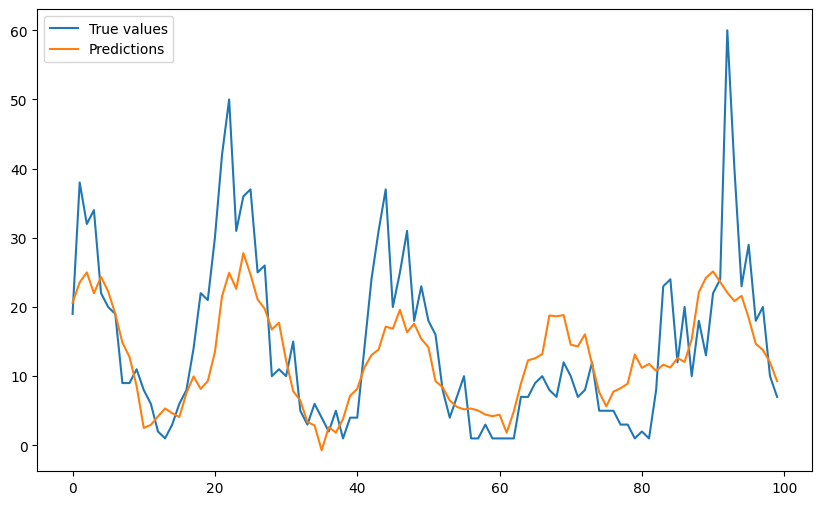

In [21]:
# plot the predictions

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ytst[0:100], label='True values')
plt.plot(predictions[0:100], label='Predictions')
plt.legend()
plt.show()

